In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import statsmodels.api

In [3]:
# preparing some data: Chilean peso to US dollar vs. copper prices
def get_daily_data_from_stooq(ticker_symbol, start_date, end_date):
    d_1 = start_date.replace("-", "")
    d_2 = end_date.replace("-", "")
    temp_url = "https://stooq.com/q/d/l/?s=" + ticker_symbol + "&d1=" \
               + d_1 + "&d2=" + d_2 + "&i=d"
    print("Getting data from URL: ", temp_url)
    data_in = pd.read_csv(temp_url, usecols=['Date', 'Close'], parse_dates=[0])
    return data_in


data_start_date = "2001-01-01"
data_end_date = "2015-12-31"
temp_ticker_symbol = "usdclp"

data_usdclp = get_daily_data_from_stooq(temp_ticker_symbol, data_start_date,
                                     data_end_date)

temp_ticker_symbol = "hg.f"
data_copper = get_daily_data_from_stooq(temp_ticker_symbol, data_start_date,
                                     data_end_date)

Getting data from URL:  https://stooq.com/q/d/l/?s=usdclp&d1=20010101&d2=20151231&i=d
Getting data from URL:  https://stooq.com/q/d/l/?s=hg.f&d1=20010101&d2=20151231&i=d


In [7]:
# display heads of the dataframes
print(data_usdclp.head())
print(data_copper.head())

        Date   Close
0 2001-01-02  575.28
1 2001-01-03  573.65
2 2001-01-04  571.22
3 2001-01-05  573.47
4 2001-01-08  574.92
        Date  Close
0 2001-01-02  81.15
1 2001-01-03  81.70
2 2001-01-04  81.10
3 2001-01-05  82.45
4 2001-01-08  82.85


In [9]:
# renaming the columns
data_usdclp.rename(columns={'Close': 'usdclp'}, inplace=True)
data_copper.rename(columns={'Close': 'copper'}, inplace=True)

In [10]:
# join the data
data_md = pd.merge(left=data_usdclp, right=data_copper,
                   left_on='Date', right_on='Date',
                   how='outer', sort=True)

In [11]:
# filling in the missing values - order of ffill and bfill is not random
data_md = data_md.set_index('Date')
data_md.fillna(method='ffill', inplace=True)
data_md.fillna(method='bfill', inplace=True)

<IPython.core.display.Javascript object>


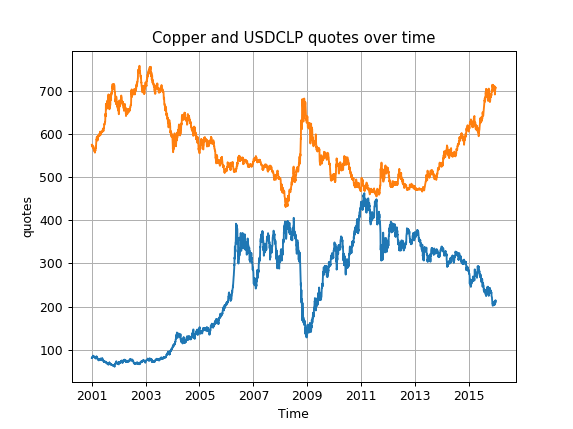

In [35]:
# overview of level plot
fig_joint_plot = plt.figure(1)
axes_joint_plot = fig_joint_plot.add_subplot(1,1,1)
axes_joint_plot.plot(data_md.loc[:,['copper', 'usdclp']])
axes_joint_plot.set_xlabel("Time")
axes_joint_plot.set_ylabel("quotes")
axes_joint_plot.set_title("Copper and USDCLP quotes over time")
axes_joint_plot.grid(True)

<IPython.core.display.Javascript object>


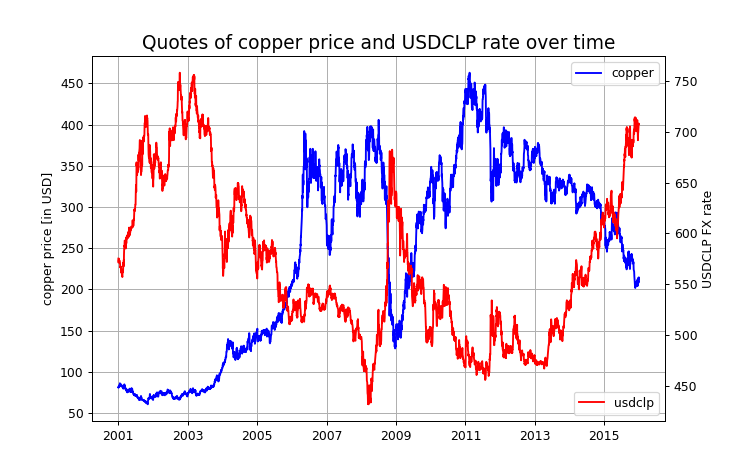

In [47]:
# after a while you might decide that two vertical axes would provide clearer picture...
fig_joint_plot_v2 = plt.figure(2)
axes_joint_plot_v2 = fig_joint_plot_v2.add_subplot(1,1,1)

# make the primary axes and the seconday axes with twinx()
axes_joint_plot_v2.plot(data_md.loc[:, 'copper'], color='blue')
axes_joint_plot_v2.set_ylabel('copper price [in USD]')
axes_joint_plot_v2_twin = axes_joint_plot_v2.twinx()
axes_joint_plot_v2.grid(True)

# make secondary plot
axes_joint_plot_v2_twin.plot(data_md.loc[:, 'usdclp'], color='red')
axes_joint_plot_v2_twin.set_ylabel('USDCLP FX rate')

# add legend & title
axes_joint_plot_v2_twin.legend(loc='lower right')
axes_joint_plot_v2.legend(loc='upper right')
axes_joint_plot_v2.set_title("Quotes of copper price and USDCLP rate over time", fontsize=15)

In [54]:
# obviously, these time series are not stationary, but let's check this formally
res_adftest_copper = statsmodels.tsa.stattools.adfuller(data_md.loc[:, 'copper'], maxlag=1)
res_adftest_usdclp = statsmodels.tsa.stattools.adfuller(data_md.loc[:, 'usdclp'], maxlag=1)
print("p-value for ADF test for copper: ", str(round(res_adftest_copper[1],2)))
print("p-value for ADF test for usdclp: ", str(round(res_adftest_usdclp[1],2)))

p-value for ADF test for copper:  0.48
p-value for ADF test for usdclp:  0.71


In [58]:
# in both cases there is no reason ro reject the null hypothesis that says that there is a unit root
# Consequently, let's calculate log returns and work on them
data_md.loc[:,'logrr_copper'] = np.log(data_md.loc[:,'copper']).diff(1)
data_md.loc[:,'logrr_usdclp'] = np.log(data_md.loc[:,'usdclp']).diff(1)
print(data_md.head())

            usdclp  copper  logrr_copper  logrr_usdclp
Date                                                  
2001-01-02  575.28   81.15           NaN           NaN
2001-01-03  573.65   81.70      0.006755     -0.002837
2001-01-04  571.22   81.10     -0.007371     -0.004245
2001-01-05  573.47   82.45      0.016509      0.003931
2001-01-08  574.92   82.85      0.004840      0.002525


<IPython.core.display.Javascript object>


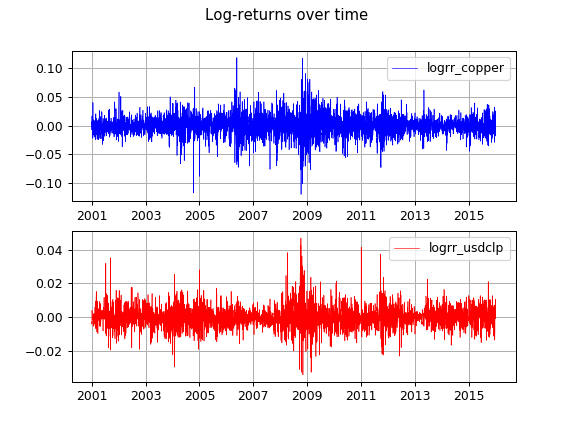

In [69]:
# a plot of log return
logrr_plot = plt.figure(3)
subplot_logrr_copper = logrr_plot.add_subplot(2,1,1)
subplot_logrr_usdclp = logrr_plot.add_subplot(2,1,2)

subplot_logrr_copper.plot(data_md.loc[:, 'logrr_copper'], color='blue', linewidth=0.5)
subplot_logrr_copper.grid(True)
subplot_logrr_copper.legend()

subplot_logrr_usdclp.plot(data_md.loc[:, 'logrr_usdclp'], color='red', linewidth=0.5)
subplot_logrr_usdclp.grid(True)
subplot_logrr_usdclp.legend()


# add title
logrr_plot.suptitle("Log-returns over time")

<IPython.core.display.Javascript object>


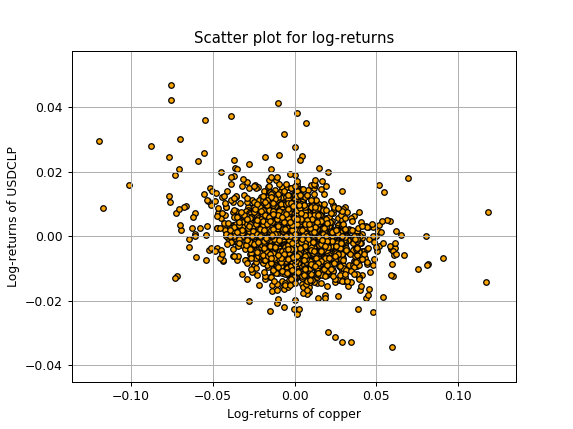

In [76]:
# now, let's plot a scatter plot with copper on the X axis
scatter_axes = data_md.plot(kind='scatter', x='logrr_copper', y='logrr_usdclp', edgecolor='black', color='orange')
scatter_axes.set_xlabel("Log-returns of copper")
scatter_axes.set_ylabel("Log-returns of USDCLP")
scatter_axes.grid(True)
scatter_axes.set_title("Scatter plot for log-returns")